<a href="https://colab.research.google.com/github/SamurAIGPT/langchain-course/blob/main/indexes/Indexes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is an Index ?

The goal of this lesson is to let you create a chatbot trained on your data using ChatGPT.

Some of the use-cases being customer support bot, company internal knowledge sharing app, document search etc.

### So how do we achieve this ?

We can feed all our document data to Langchain and make it answer questions but it is not scalable as ChatGPT has input character limit

Thus as an alternative, we split the entire input documents into chunks and train our chatbot on it. Now when a user asks a query, only the relevant documents are fetched and passed on to ChatGPT. Since the data input to ChatGPT is only relevant text data and not the entire data, there is no problem with input limit

We implement this in Langchain using Indexes

### Embeddings

Before we start with Langchain indexes we should understand embeddings. As humans we can understand language with quite ease but computers only understand numbers

Thus if we have to feed text as input to a computer, we have to convert it to numbers. But these number can't be any random number, they should preserve the meaning of the text input. This is where embeddings come

More details on what is an embedding is discussed in Lesson 2 of the course https://github.com/SamurAIGPT/langchain-course/blob/main/models/Models.ipynb

Now that we understand embeddings, OpenAI has a LLM called Ada which can convert text into embeddings. Langchain uses it to create embeddings for any text

### Vector db

We have created embeddings for the input text but we need a way to store it and make quick queries. Traditional database are not designed for these tasks. Thus we need a specialized database for this task called as Vector db which allows for quick retrieval of vectors

There are many popular vector db available in the market. Langchain uses Chroma db by default. It is free to use and runs locally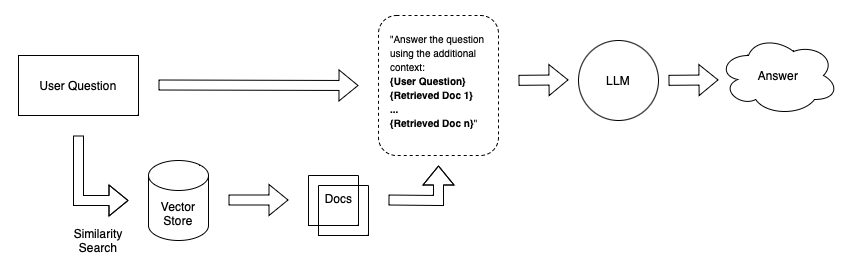

Here is the entire flow for question answering with our chatbot

1. User asks a question
2. A similarity search is performed to identify all similar text from our vector store/db
3. The user question combined with the relevant documents are passed to ChatGPT and the answer is generated

Let's see the code example for this

#### Install dependencies

In [ ]:
!pip install langchain
!pip install openai
!pip install tiktoken
!pip install chromadb

#### Download sample training data

In [ ]:
!wget https://raw.githubusercontent.com/hwchase17/chat-your-data/master/state_of_the_union.txt

#### Document Loader

Document Loader is a Lnagchain abstract which helps you fetch training data from various sources such as a webpage, youtube video, notion doc etc.

For this example we need to load a text document. Thus we will be using TextLoader

In [1]:
from langchain.document_loaders import TextLoader
loader = TextLoader('state_of_the_union.txt', encoding='utf8')
documents = loader.load()

#### Document Splitter

As we discussed above, we take the input data documents and split it to chunks before we create embeddings and store them. For this we use document splitters. There are various document splitters Langchain supports. 

We will be using a simple TextSplitter which splits the documents based on character limit. When splitting we allow a overlap of few characters across consecutive splits such that the context is not broken and is passed across both the documents

In [2]:
from langchain.text_splitter import CharacterTextSplitter
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
texts = text_splitter.split_documents(documents)

#### Let's create the embeddings for these chunks now and store them in our vectorstore Chromadb. This creates an index which contains all this information. Place your OpenAI key in place of your-openai-key

In [3]:
from langchain.embeddings import OpenAIEmbeddings
import os
from langchain.vectorstores import Chroma
os.environ["OPENAI_API_KEY"] = "your-openai-key"
embeddings = OpenAIEmbeddings()
db = Chroma.from_documents(texts, embeddings)

Now we can create a Q&A chain to which we can make queries and get answers based on our training data powered by ChatGPT. The Q&A chain needs as input a retriever created from our index above

In [4]:
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
retriever = db.as_retriever()
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=retriever)

Now we can make any queries to our Q&A chain and get answer powered by ChatGPT

In [5]:
query = "What did the president say about Ketanji Brown Jackson"
qa.run(query)

" The president said that Ketanji Brown Jackson is one of our nation's top legal minds, a consensus builder, and has received a broad range of support from the Fraternal Order of Police to former judges appointed by Democrats and Republicans."